# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,305
unique,2
top,warning
freq,304


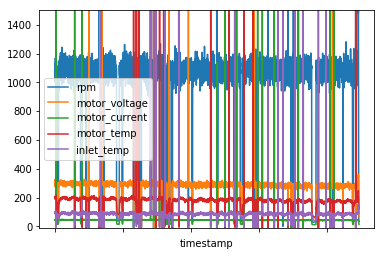

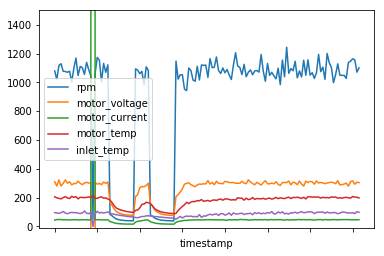

In [2]:
# To help you get started...
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import lifelines
from datetime import datetime

%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp")
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp")

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

display(rms.describe())
display(alarms.describe())

There are clearly some extreme values that are nonsense measurements.  My first step is to deal with most of these in a sinlge unit so that I can then do some subsequest exploratory analyses.  To do initially deal with these extreme values, if I found values larger or smaller than values that make sense (by some very liberal criteria related to what I know about RPM and temperature ranges), then I replaced that measurement with the measurement immediately before it.

The resulting exploratory analyses revealed that there are still some issues with the data that require cleaning.  Specifically, there are spikes in voltage and current that do not relate to the current RPMs of the widget.  Also, there were times when the motor temperature was notably cooler than the inlet temperature, which does not make sense.

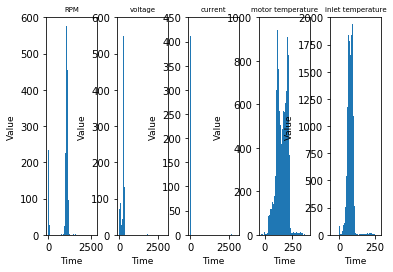

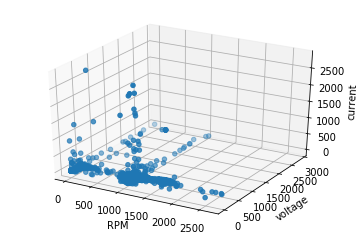

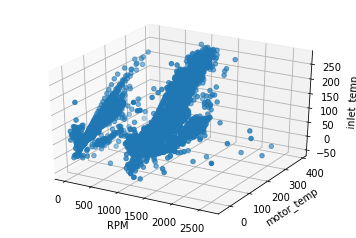

In [3]:
sensibleRanges = [[0,2700],
 [0,3000],
 [0,3000],
 [-30,390],
 [-50, 280]]

for measurementNum in range(rms.shape[0]):
    for measurementType in range(rms.shape[1]):
        if measurementNum == 0 and \
            (rms.iloc[measurementNum,measurementType] < sensibleRanges[measurementType][0] or \
             rms.iloc[measurementNum,measurementType] > sensibleRanges[measurementType][1]):
            rms.iloc[measurementNum,measurementType] = rms.iloc[:,measurementType].median()
        elif rms.iloc[measurementNum,measurementType] < sensibleRanges[measurementType][0] or \
            rms.iloc[measurementNum,measurementType] > sensibleRanges[measurementType][1]:
            rms.iloc[measurementNum,measurementType] = rms.iloc[measurementNum-1,measurementType]

ylims = [600,600,450,1000,2000]
fig, axes = plt.subplots(1,5)
for measurementType in range(rms.shape[1]):
    axes[measurementType].hist(rms.iloc[:,measurementType], \
                               range(sensibleRanges[measurementType][0],sensibleRanges[measurementType][1]))
    #axes[measurementType].set_title('measurement type %i'%(measurementType), fontsize=7)
    axes[measurementType].set_xlabel('Time', fontsize=9)
    axes[measurementType].set_ylabel('Value', fontsize=9)
    axes[measurementType].set_ylim(0,ylims[measurementType])
axes[0].set_title('RPM', fontsize=7)
axes[1].set_title('voltage', fontsize=7)
axes[2].set_title('current', fontsize=7)
axes[3].set_title('motor temperature', fontsize=7)
axes[4].set_title('inlet temperature', fontsize=7)
fig.subplots_adjust(wspace = 0.4,hspace = 0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rms['rpm'],rms['motor_voltage'],rms['motor_current']) # plot a particular metric
ax.set_xlabel('RPM')
ax.set_ylabel('voltage')
ax.set_zlabel('current')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rms['rpm'],rms['motor_temp'],rms['inlet_temp']) # plot a particular metric
ax.set_xlabel('RPM')
ax.set_ylabel('motor_temp')
ax.set_zlabel('inlet_temp')
plt.show()


My next step was to continue cleaning the data.  Wherever there was a spike in voltage or current or there was a nonsense motor temperature reading, I replaced the current reading with the one immediately before it.  I then plot the cleaned data to observe some patterns.

One pattern that I observed was that RPM has roughly three main states, which can be seen as clusters in the graphs. The first is a slow state with RPM values in the 0-150 range, but typically on the lower end of that range.  The second and most typical state is one in the range of approcimately 1400-1900 RPMs.  The third state is atypical, but falls roughly in the 2200-2700 RPM range.

A different pattern that I observe is that voltage and current are highly correlated (as they should be) but, the number of RPMs does not relate particularly strongly to either of these readings.

Likewise, another pattern that I observe is that motor temperature and inlet temperature seem to be highly correlated; however, the number of RPMs does not relate particularly strongly to either of these temperature readings.

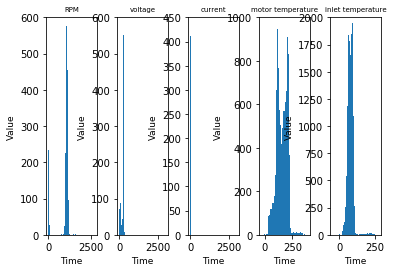

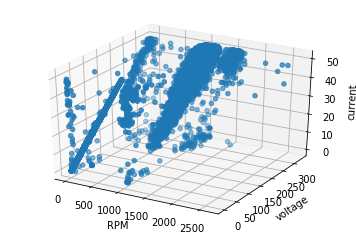

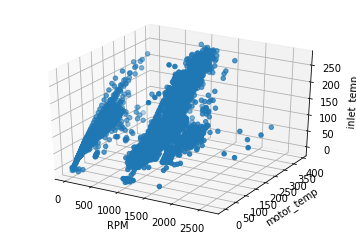

In [4]:
highV = rms['motor_voltage'].quantile(0.99,'linear')
highC = rms['motor_current'].quantile(0.99,'linear')

for measurementNum in range(rms.shape[0]):
    for measurementType in range(rms.shape[1]):
        if measurementNum == 0 and \
            rms.iloc[0,3] < rms.iloc[0,4]-5:
            rms.iloc[0,3] =  rms.iloc[1,3]
        elif rms.iloc[measurementNum,3] < rms.iloc[measurementNum,4]-5:
            rms.iloc[measurementNum,3] = rms.iloc[measurementNum-1,3]

        if measurementNum == 0 and  rms.iloc[0,4] <= 20 and \
            rms.iloc[0,4] < rms.iloc[0,3]-10:
            rms.iloc[0,4] =  rms.iloc[1,4]
        elif rms.iloc[measurementNum,4] <= 20 and \
            rms.iloc[measurementNum,4] < rms.iloc[measurementNum,3]-10:
            rms.iloc[measurementNum,4] = rms.iloc[measurementNum-1,4]

        if measurementNum == 0 and \
            rms.iloc[0,1] > highV:
            rms.iloc[0,1] =  rms.iloc[1,1]
        elif rms.iloc[measurementNum,1] > highV:
            rms.iloc[measurementNum,1] = rms.iloc[measurementNum-1,1]

        if measurementNum == 0 and \
            rms.iloc[0,2] > highC:
            rms.iloc[0,2] =  rms.iloc[1,2]
        elif rms.iloc[measurementNum,2] > highC:
            rms.iloc[measurementNum,2] = rms.iloc[measurementNum-1,2]

ylims = [600,600,450,1000,2000]
fig, axes = plt.subplots(1,5)
for measurementType in range(rms.shape[1]):
    axes[measurementType].hist(rms.iloc[:,measurementType], \
                               range(sensibleRanges[measurementType][0],sensibleRanges[measurementType][1]))
    #axes[measurementType].set_title('measurement type %i'%(measurementType), fontsize=7)
    axes[measurementType].set_xlabel('Time', fontsize=9)
    axes[measurementType].set_ylabel('Value', fontsize=9)
    axes[measurementType].set_ylim(0,ylims[measurementType])
axes[0].set_title('RPM', fontsize=7)
axes[1].set_title('voltage', fontsize=7)
axes[2].set_title('current', fontsize=7)
axes[3].set_title('motor temperature', fontsize=7)
axes[4].set_title('inlet temperature', fontsize=7)
fig.subplots_adjust(wspace = 0.4,hspace = 0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rms['rpm'],rms['motor_voltage'],rms['motor_current']) # plot a particular metric
ax.set_xlabel('RPM')
ax.set_ylabel('voltage')
ax.set_zlabel('current')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rms['rpm'],rms['motor_temp'],rms['inlet_temp']) # plot a particular metric
ax.set_xlabel('RPM')
ax.set_ylabel('motor_temp')
ax.set_zlabel('inlet_temp')
plt.show()

I then plotted the readings a couple different way in 2-dimensions as a sanity check that my cleaning went as expected.  Inlet temperature should rarely be much higher than the motor tempurature, and this holds true.

Also, I checked out the separation between the RPM ranges.

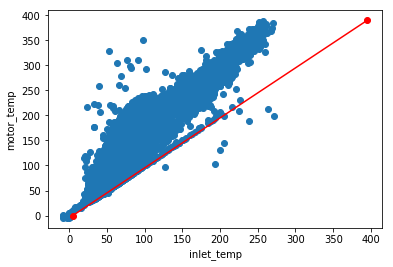

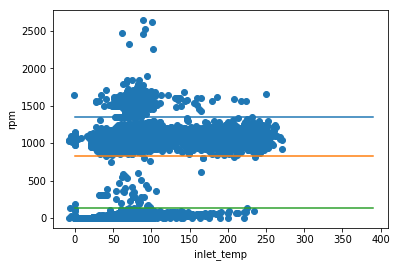

In [5]:
fig = plt.figure()
plt.scatter(rms['inlet_temp'],rms['motor_temp']) # plot a particular metric
plt.xlabel('inlet_temp')
plt.ylabel('motor_temp')
x1, y1 = [5, 395], [0, 390]
plt.plot(x1, y1, 'ro-')
plt.show()

fig = plt.figure()
plt.scatter(rms['inlet_temp'],rms['rpm']) # plot a particular metric
plt.xlabel('inlet_temp')
plt.ylabel('rpm')
x1, y1 = [0, 390], [1355, 1355]
x2, y2 = [0, 390], [830, 830]
x3, y3 = [0, 390], [130, 130]
plt.plot(x1, y1, x2, y2, x3, y3)
plt.show()


I realized that the other widgetes had very similar patterns, so I went on to apply the same data cleaning for all other widgets and put all widget data into a single dataframe.  I also added a few more columns to the dataframe that I would need for a survival analysis.  Specifically, I added a duration column (quantified in seconds since the first measurement of that widget).  I also added a widget number column so I could keep track of the widgets.

In [6]:
sensibleRanges = [[0,2700],
                  [0,3000],
                  [0,3000],
                  [-30,390],
                  [-50, 280]]

numWidgets = 20
survivalTimes = [0]*numWidgets
index = 0
for widgetNum in range(numWidgets):
    del rms
    if widgetNum < 10:
        strWidgNum = '0%s'%str(widgetNum)
    else:
        strWidgNum = str(widgetNum)
    rms = load_rms('data/train/unit00%s_rms.csv'%(strWidgNum))

    highV = rms['motor_voltage'].quantile(0.99,'linear')
    highC = rms['motor_current'].quantile(0.99,'linear')

    for measurementNum in range(rms.shape[0]):
        for measurementType in range(rms.shape[1]):
            if measurementNum == 0 and \
                (rms.iloc[measurementNum,measurementType] < sensibleRanges[measurementType][0] or \
                 rms.iloc[measurementNum,measurementType] > sensibleRanges[measurementType][1]):
                rms.iloc[measurementNum,measurementType] = rms.iloc[:,measurementType].median()
            elif rms.iloc[measurementNum,measurementType] < sensibleRanges[measurementType][0] or \
                rms.iloc[measurementNum,measurementType] > sensibleRanges[measurementType][1]:
                rms.iloc[measurementNum,measurementType] = rms.iloc[measurementNum-1,measurementType]

        if measurementNum == 0 and \
            rms.iloc[0,3] < rms.iloc[0,4]-5:
            rms.iloc[0,3] =  rms.iloc[1,3]
        elif rms.iloc[measurementNum,3] < rms.iloc[measurementNum,4]-5:
            rms.iloc[measurementNum,3] = rms.iloc[measurementNum-1,3]

        if measurementNum == 0 and  rms.iloc[0,4] <= 20 and \
            rms.iloc[0,4] < rms.iloc[0,3]-10:
            rms.iloc[0,4] =  rms.iloc[1,4]
        elif rms.iloc[measurementNum,4] <= 20 and \
            rms.iloc[measurementNum,4] < rms.iloc[measurementNum,3]-10:
            rms.iloc[measurementNum,4] = rms.iloc[measurementNum-1,4]

        if measurementNum == 0 and \
            rms.iloc[0,1] > highV:
            rms.iloc[0,1] =  rms.iloc[1,1]
        elif rms.iloc[measurementNum,1] > highV:
            rms.iloc[measurementNum,1] = rms.iloc[measurementNum-1,1]

        if measurementNum == 0 and \
            rms.iloc[0,2] > highC:
            rms.iloc[0,2] =  rms.iloc[1,2]
        elif rms.iloc[measurementNum,2] > highC:
            rms.iloc[measurementNum,2] = rms.iloc[measurementNum-1,2]


    initTime = datetime.strptime(rms.index[0][0:26],'%Y-%m-%d %H:%M:%S.%f')
    durations = [0]*(rms.shape[0])
    indices = [0]*(rms.shape[0])
    for measurementNum in range(rms.shape[0]):
        duration = datetime.strptime(rms.index[measurementNum][0:26],'%Y-%m-%d %H:%M:%S.%f') - initTime
        duration = duration.days*24*60*60 + duration.seconds
        durations[measurementNum] = duration
        indices[measurementNum] = index
        index += 1
    survivalTimes[widgetNum] = durations[len(durations)-1]
    rms.index = indices
    rms = rms.assign(duration=pd.Series(durations).values)
    failures = [False]*rms.shape[0]
    failures[len(failures)-1] = True
    rms = rms.assign(failure=pd.Series(failures).values)
    rms = rms.assign(widgetNum=pd.Series([widgetNum]*rms.shape[0]).values)
    if not widgetNum:
        rms_all = rms
    else:
        rms_all = pd.concat([rms_all,rms])
        

Next I tried out a Cox’s Time Varying Proportional Hazard model.  I chose this model because it allows me to incorporate time-varying information into hazard estimations.  I need to do this, if I am going to be able to use the time-varying RPM, current, voltage, and temperature information.  The downside is that I do not have many cases fit the model to, so this may not work out so well.

The model reports that RPM information is significantly predictive of failure, but the reported liklihood of the entire model indicates that it is not a good model compared to a model naive to these time-varying factors.

Iteration 1: norm_delta = 1.591268, step_size = 0.500, ll = -242.691556, seconds_since_start = 1.4
Iteration 2: norm_delta = 0.188286, step_size = 0.500, ll = -239.305965, seconds_since_start = 2.8
Iteration 3: norm_delta = 0.133840, step_size = 0.500, ll = -237.267366, seconds_since_start = 4.2
Iteration 4: norm_delta = 0.104808, step_size = 0.600, ll = -236.384390, seconds_since_start = 5.6
Iteration 5: norm_delta = 0.066196, step_size = 0.720, ll = -235.959178, seconds_since_start = 7.0
Iteration 6: norm_delta = 0.032777, step_size = 0.864, ll = -235.810285, seconds_since_start = 8.4
Iteration 7: norm_delta = 0.009169, step_size = 0.950, ll = -235.781125, seconds_since_start = 9.8
Iteration 8: norm_delta = 0.000795, step_size = 0.950, ll = -235.779529, seconds_since_start = 11.3
Iteration 9: norm_delta = 0.000042, step_size = 0.950, ll = -235.779519, seconds_since_start = 13.7
Iteration 10: norm_delta = 0.000002, step_size = 0.950, ll = -235.779519, seconds_since_start = 15.2
Conver

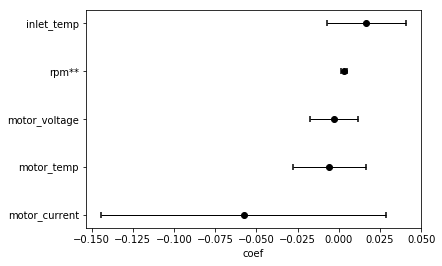

In [7]:
from lifelines.utils import to_long_format
rms_all = to_long_format(rms_all, duration_col="duration")
# print(rms_all.head())

rms_all = rms_all.loc[~((rms_all['start'] == rms_all['stop']) & (rms_all['start'] == 0))]
from lifelines import CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()
ctv.fit(rms_all, id_col="widgetNum", event_col="failure", start_col="start", stop_col="stop", show_progress=True, step_size=0.5)
ctv.print_summary()
ctv.plot()

I give the model another shot, but this time eliminating the time-varying predictors besides RPM.  This model also does poorly, so it must be abandoned.

Iteration 1: norm_delta = 0.169970, step_size = 0.500, ll = -242.691556, seconds_since_start = 0.7
Iteration 2: norm_delta = 0.144021, step_size = 0.500, ll = -241.850615, seconds_since_start = 1.4
Iteration 3: norm_delta = 0.115932, step_size = 0.500, ll = -241.437134, seconds_since_start = 2.6
Iteration 4: norm_delta = 0.102449, step_size = 0.600, ll = -241.246819, seconds_since_start = 3.4
Iteration 5: norm_delta = 0.071742, step_size = 0.720, ll = -241.158326, seconds_since_start = 4.3
Iteration 6: norm_delta = 0.033133, step_size = 0.864, ll = -241.132120, seconds_since_start = 5.2
Iteration 7: norm_delta = 0.006346, step_size = 0.950, ll = -241.128596, seconds_since_start = 6.0
Iteration 8: norm_delta = 0.000357, step_size = 0.950, ll = -241.128495, seconds_since_start = 6.7
Iteration 9: norm_delta = 0.000018, step_size = 0.950, ll = -241.128495, seconds_since_start = 7.4
Iteration 10: norm_delta = 0.000001, step_size = 0.950, ll = -241.128495, seconds_since_start = 8.1
Convergen

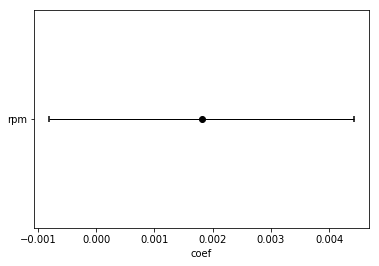

In [8]:
ctv.fit(rms_all.drop(['motor_voltage','motor_current','motor_temp','inlet_temp'],axis=1), id_col="widgetNum", event_col="failure", start_col="start", stop_col="stop", show_progress=True, step_size=0.5)
ctv.print_summary()
ctv.plot()
plt.show()

So far, the best idea that I can give to ExampleCo so that they can estimate the probability that a widget will fail soon is for them to look at the historic survival rates for various points of time using the training dataset.

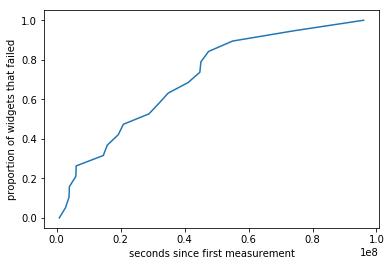

In [9]:
x = np.sort(survivalTimes)
y = np.arange(len(x))/float(len(x)-1)
plt.plot(x, y)
plt.xlabel('seconds since first measurement')
plt.ylabel('proportion of widgets that failed')
plt.show()

Most of the widgets in the test dataset are almost exaclty 1 month old.  Of widgets this age, only 5% are expected to fail, if one estimates failure rate using the training dataset.  So while I cannot tell ExampleCo, which specific widgets in the test dataset are most likely to fail compared to the others, I can tell them that none of them are highly likely to fail soon.  Below I display a table with the test widget number, its age, and the proportion of training widgets that failed by that age.

In [12]:
numWidgets = 30
ages = [0]*numWidgets
ages_long = [0]*numWidgets
propFail = [0]*numWidgets
widgetNums = range(20,numWidgets+20)
for widgetNum in range(20,numWidgets+20):
        strWidgNum = str(widgetNum)
        rms = load_rms('data/test/unit00%s_rms.csv'%(strWidgNum))
        initTime = datetime.strptime(rms.index[0][0:26],'%Y-%m-%d %H:%M:%S.%f')
        maxInd = rms.shape[0]-1
        age = datetime.strptime(rms.index[maxInd][0:26],'%Y-%m-%d %H:%M:%S.%f') - initTime
        ages_long[widgetNum-20] = age
        age = age.days*24*60*60 + age.seconds
        ages[widgetNum-20] = age
        B=np.array([a<age for a in survivalTimes])
        propFail[widgetNum-20] = np.mean(B)

newWidgetsPredictions = pd.DataFrame(ages_long, index=widgetNums, columns=['age'])
newWidgetsPredictions = newWidgetsPredictions.assign(Historic_Failure_Rate=pd.Series(propFail).values)
newWidgetsPredictions.head(30)

,age,Historic_Failure_Rate
20,30 days 23:56:45.634982,0.05
21,30 days 23:59:27.654605,0.05
22,30 days 23:59:19.496138,0.05
23,8 days 10:10:26.461886,0.00
24,30 days 23:58:17.593777,0.05
25,30 days 23:59:50.748154,0.05
26,30 days 23:59:05.351372,0.05
27,30 days 23:59:13.326338,0.05
28,31 days 00:01:53.982283,0.05
29,30 days 23:59:57.800738,0.05


If I had had more time, there are at least a couple other things I would have tried.

I had not made use of the warning and error data.  I would have liked to try to see if the temporal density of warning messages predicts upcoming failure.

Also, it may have been valuable to try some cumulative effects models.  Perhaps more time spent in one of the three RPM states is predictive of failure, or more time spent in hot temperatures, etc.

Als, these analyses will have to be for another day.